<div style='border: 3px solid none; background-color: #00000; font-family: Times New Roman; font-size: 80%; padding: 10px'>

<pre>
<span style="font-weight: bold; color: darkgreen;">Project file organization: </span>
Evi Project Modeling/ 💻
│
├── data/
│   ├── Cleaned_synthetic_family_data_less_than_48.csv
│   └── holidays.csv
│
├── models/
│   ├── feature_engineering_transformer.pkl
│   └── optimized_stacking_regressor_advanced.pkl
│
├── notebooks/
│   └── main_notebook.ipynb
│
├── src/
│   ├── __init__.py
│   ├── utils.py
│   └── transformers.py
│
├── requirements.txt
└── README.md
</pre>

</div>


<div style="border: 3px solid none; background-color:rgb(35, 35, 35); padding: 10px; direction: rtl;">


* **النموذج يقيس ويدرس سلوك البيت 🏠**
- •	الهدف الأساسي:
عمل النموذج الأساسي EVI هو الدراسة والتنبؤ لتحليل السلوك واتخاذ القرار المناسب للمحافظة على استهلاك الكهرباء ⚡️💡


  - •	تفاصيل القياسات:
	- •	الدخول والخروج لكل شخص على حده:
	- •	الطلاب: يتم قياس الأوقات من يوم الأحد إلى الخميس ⏰
	- •	الموظفون: حسب دوام القطاع العام أو الخاص 🧑‍💼
	- •	أحوال الطقس:
	- •	(حرارة 🌡️ - أمطار 🌧️ - رطوبة 💧 - برودة ❄️)
	- •	مجمّعة حسب المدينة 📍 من المركز الوطني للأرصاد 🌐
	- •	تجميع العطل:
	- •	عطل الطلاب: من وزارة التعليم 📚
	- •	عطل الموظفين: من وزارة الموارد البشرية 🗂️
  - تفاصيل مجموعة البيانات:
	- •	سلوك الأفراد: بيانات افتراضية لمدة سنتين 🕒
	- •	الطقس: بيانات حقيقية 📊
	- •	العطل: بيانات حقيقية  وموثوقة 📈

  
   
  

In [2]:
import sys
import os

# تحديد المسار المطلق لمجلد المشروع
project_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, project_path)

<a id="2"></a>
# <p style="padding:10px;background-color:#273c75 ;margin:0;color:#E2EEF3;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> Imports and Custom Transformers </p>

In [3]:
# notebooks/main_notebook.ipynb - Cell 1: Imports and Custom Transformers

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform, randint
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
import lightgbm as lgb
import plotly.express as px
import time

# تجاهل التحذيرات المستقبلية
warnings.simplefilter(action='ignore', category=FutureWarning)

# إعداد autoreload لتحميل التعديلات التلقائية في الوحدات الخارجية
%load_ext autoreload
%autoreload 2

# استيراد الوظائف والمتحولات من الوحدات المنفصلة
from src.utils import categorize_weather
from src.transformers import FeatureEngineeringTransformer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 <a id="2"></a>
# <p style="padding:10px;background-color:#273c75 ;margin:0;color:#E2EEF3;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> Load Data, Feature Engineering, Create Model </p>

In [4]:
def read_and_preprocess_data(file_path):
    """
    قراءة بيانات CSV ومعالجة الأعمدة الأساسية.
    
    Args:
        file_path (str): مسار ملف CSV.
    
    Returns:
        pd.DataFrame: بيانات مع معالجة مسبقة.
    """
    df = pd.read_csv(file_path)
    
    # تحويل Timestamp إلى datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    
    # حذف الصفوف التي تحتوي على Timestamp غير صالح
    df.dropna(subset=['Timestamp'], inplace=True)
    
    # التأكد من أن PersonID هو نص
    df['PersonID'] = df['PersonID'].astype(str).str.strip()
    
    return df

def create_model_data(df):
    """
    إعداد بيانات النموذج مع ميزات إضافية.
    
    Args:
        df (pd.DataFrame): DataFrame بعد هندسة الميزات.
    
    Returns:
        pd.DataFrame: بيانات النموذج مع الميزات المطلوبة.
    """
    rows = []
    for person_id, person_df in df.groupby('PersonID'):
        person_df = person_df.reset_index(drop=True)
        for i in range(len(person_df) - 1):
            current_event = person_df.iloc[i]
            next_event = person_df.iloc[i + 1]
            if current_event['Event'] == 'Enter' and next_event['Event'] == 'Exit':
                time_diff = (next_event['Timestamp'] - current_event['Timestamp']).total_seconds() / 3600.0

                # إضافة ميزات زمنية جديدة
                same_day_events = person_df[person_df['Date'] == current_event['Date']]
                same_day_entries = same_day_events[same_day_events['Event'] == 'Enter']['Timestamp'].tolist()
                same_day_exits = same_day_events[same_day_events['Event'] == 'Exit']['Timestamp'].tolist()
                
                duration_diffs = [ (exit_time - enter_time).total_seconds() / 3600.0 
                                   for enter_time in same_day_entries 
                                   for exit_time in same_day_exits 
                                   if exit_time > enter_time]
                duration_diff = duration_diffs[0] if duration_diffs else 0

                row = {
                    'PersonID': person_id,
                    'Duration_Hours': time_diff,
                    'DayOfWeek': current_event['DayOfWeek'],
                    'Hour': current_event['Hour'],
                    'Temp': current_event['Temp'],
                    'Wind': current_event['Wind'],
                    'Humidity': current_event['Humidity'],
                    'IsWeekend': current_event['IsWeekend'],
                    'IsHoliday': current_event['IsHoliday'],
                    'Temp_Humidity_Interaction': current_event['Temp_Humidity_Interaction'],
                    'WeekOfYear': current_event['WeekOfYear'],
                    'DayOfYear': current_event['DayOfYear'],
                    'TimeSinceLastEvent': current_event['TimeSinceLastEvent'],
                    'LogTimeSinceLastEvent': current_event['LogTimeSinceLastEvent'],
                    'SameDayDurationDiffs': duration_diff
                }

                # إضافة ميزات WeatherCat
                weather_cat_cols = [col for col in df.columns if 'WeatherCat_' in col]
                for col in weather_cat_cols:
                    row[col] = current_event[col]

                rows.append(row)
    
    df_model = pd.DataFrame(rows)

    # التعامل مع القيم المفقودة في SameDayDurationDiffs
    df_model['SameDayDurationDiffs'].fillna(0, inplace=True)

    # حساب المتوسطات
    df_model = df_model.merge(
        df_model.groupby('PersonID')['Duration_Hours'].mean().rename('AvgDurationPerPerson'), 
        on='PersonID', 
        how='left'
    )
    df_model = df_model.merge(
        df_model.groupby('DayOfWeek')['Duration_Hours'].mean().rename('AvgDurationPerDayOfWeek'), 
        on='DayOfWeek', 
        how='left'
    )
    df_model = df_model.merge(
        df_model.groupby('Hour')['Duration_Hours'].mean().rename('AvgDurationPerHour'), 
        on='Hour', 
        how='left'
    )

    # إضافة ميزات Lagged Features
    for lag in [1, 2, 3]:
        df_model[f'Duration_Hours_Lag{lag}'] = df_model.groupby('PersonID')['Duration_Hours'].shift(lag).fillna(df_model['Duration_Hours'].mean())

    # إضافة ميزات Rolling Window Features
    for window in [3, 5]:
        df_model[f'Duration_Hours_RollingMean{window}'] = df_model.groupby('PersonID')['Duration_Hours'].rolling(window=window).mean().reset_index(0, drop=True).fillna(df_model['Duration_Hours'].mean())

    return df_model

def remove_outliers(df_model):
    """
    إزالة القيم الشاذة في Duration_Hours باستخدام Z-Score.
    
    Args:
        df_model (pd.DataFrame): بيانات النموذج.
    
    Returns:
        pd.DataFrame: بيانات النموذج بعد إزالة القيم الشاذة.
    """
    z_scores = (df_model['Duration_Hours'] - df_model['Duration_Hours'].mean()) / df_model['Duration_Hours'].std()
    df_model = df_model[np.abs(z_scores) < 3]
    return df_model

def train_model(X, y):
    """
    تدريب نموذج Stacking Regressor باستخدام RandomizedSearchCV.
    
    Args:
        X (pd.DataFrame): ميزات التدريب.
        y (pd.Series): المتغير المستهدف.
    
    Returns:
        Pipeline: أفضل نموذج تم تدريبه.
        RandomizedSearchCV: كائن RandomizedSearchCV بعد التدريب.
        pd.Series: القيم الحقيقية للاختبار.
        pd.Series: القيم المتنبأة للاختبار.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # تعريف الميزات الرقمية والفئوية
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # تعريف المعالجات للميزات الرقمية والفئوية
    numeric_transformer = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    
    # تعريف المعلمات للتحسين
    param_distributions = {
        'model__catboost__iterations': randint(400, 600),
        'model__catboost__depth': randint(7, 11),
        'model__catboost__learning_rate': uniform(0.01, 0.1),
        'model__random_forest__n_estimators': randint(100, 200),
        'model__random_forest__max_depth': randint(10, 15),
        'model__lgbm__n_estimators': randint(100, 300),
        'model__lgbm__max_depth': randint(6, 12),
        'model__lgbm__learning_rate': uniform(0.01, 0.1),
    }
    
    # تعريف النماذج الأساسية للـ Stacking Regressor
    estimators = [
        ('catboost', CatBoostRegressor(verbose=0, random_seed=42)),
        ('random_forest', RandomForestRegressor(random_state=42)),
        ('lgbm', lgb.LGBMRegressor(random_state=42, verbose=-1))
    ]
    
    stacking_regressor = StackingRegressor(
        estimators=estimators, 
        final_estimator=Ridge(alpha=1.0)
    )
    
    # تعريف الـ Pipeline الكامل مع محولات المعالجة
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', stacking_regressor)
    ])
    
    # تعريف RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline, 
        param_distributions=param_distributions, 
        n_iter=75, 
        cv=5,
        scoring='neg_mean_absolute_error', 
        n_jobs=-1, 
        random_state=42
    )
    
    # بدء التوقيت
    start_time = time.time()
    print("\nStarting parameter tuning using RandomizedSearchCV...")
    random_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    print(f"Parameter tuning completed in {elapsed_time:.2f} seconds.")
    
    best_params = random_search.best_params_
    print("\nBest parameters:", best_params)
    
    best_model = random_search.best_estimator_
    
    # تقييم النموذج على مجموعة الاختبار
    y_pred = best_model.predict(X_test)
    
    print("\nPerformance metrics of the optimized model:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
    print(f"R²: {r2_score(y_test, y_pred)}")
    
    return best_model, random_search, y_test, y_pred

def save_model(model, file_path):
    """
    حفظ النموذج باستخدام joblib.
    
    Args:
        model (Pipeline): النموذج المدرب.
        file_path (str): مسار حفظ النموذج.
    """
    joblib.dump(model, file_path)
    print(f"\nThe optimized model has been saved to file '{file_path}'.")

def save_feature_engineer(transformer, file_path):
    """
    حفظ محول هندسة الميزات باستخدام joblib.
    
    Args:
        transformer (FeatureEngineeringTransformer): محول هندسة الميزات.
        file_path (str): مسار حفظ المحول.
    """
    joblib.dump(transformer, file_path)
    print(f"FeatureEngineeringTransformer has been saved to file '{file_path}'.")

def plot_avg_duration_per_day(df_model):
    """
    رسم متوسط مدة التواجد لكل يوم من أيام الأسبوع.
    
    Args:
        df_model (pd.DataFrame): بيانات النموذج.
    """
    # حساب متوسط مدة التواجد لكل يوم من أيام الأسبوع
    avg_duration_per_day = df_model.groupby('DayOfWeek')['Duration_Hours'].mean().reset_index()

 <a id="2"></a>
# <p style="padding:10px;background-color:#273c75 ;margin:0;color:#E2EEF3;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> Main Function,Train, Save Model </p>

In [ ]:
# الدالة الرئيسية
def main():
    # مسار ملف البيانات
    file_path = "../data/Cleaned_synthetic_family_data_less_than_48.csv"
    
    # قراءة ومعالجة البيانات
    df = read_and_preprocess_data(file_path)
    
    # تطبيق محول هندسة الميزات مع تحديد ملف العطلات
    fe_transformer = FeatureEngineeringTransformer(holidays_file='../data/holidays.csv')
    df = fe_transformer.fit_transform(df)
    
    # حفظ محول هندسة الميزات
    save_feature_engineer(fe_transformer, '../models/feature_engineering_transformer.pkl')
    
    # التحقق من الأعمدة بعد تطبيق المحول
    print("Columns after applying FeatureEngineeringTransformer:", df.columns.tolist())
    
    # إنشاء بيانات النموذج
    df_model = create_model_data(df)
    
    # التحقق من الأعمدة بعد إنشاء بيانات النموذج
    print("Columns in the model data:", df_model.columns.tolist())
    
    # إزالة القيم الشاذة
    df_model = remove_outliers(df_model)
   
    # تعريف الأعمدة المطلوبة
    feature_cols = [
        'DayOfWeek', 'Hour', 'Temp', 'Wind', 'Humidity', 'IsWeekend', 'IsHoliday',
        'Temp_Humidity_Interaction', 'WeekOfYear', 'DayOfYear', 'TimeSinceLastEvent',
        'LogTimeSinceLastEvent', 'AvgDurationPerPerson', 'SameDayDurationDiffs',
        'AvgDurationPerDayOfWeek', 'AvgDurationPerHour'
    ] + [col for col in df_model.columns if 'WeatherCat_' in col or 'Duration_Hours_Lag' in col or 'Duration_Hours_RollingMean' in col]
    
    # التحقق من وجود جميع الأعمدة المطلوبة
    missing_cols = set(feature_cols) - set(df_model.columns)
    if missing_cols:
        print(f"Missing columns in the model data: {missing_cols}")
    else:
        print("All required columns are present in the model data.")
    
    # اختيار الميزات والمتغير المستهدف
    X = df_model[feature_cols]
    y = df_model['Duration_Hours']
    
    # تدريب النموذج
    best_model, random_search, y_test, y_pred = train_model(X, y)
    
    # إرجاع المتغيرات اللازمة للرسوم البيانية
    return best_model, random_search, y_test, y_pred, df_model

# تشغيل الدالة الرئيسية وتخزين النتائج
best_model, random_search, y_test, y_pred, df_model = main()


 <a id="2"></a>
# <p style="padding:10px;background-color:#273c75 ;margin:0;color:#E2EEF3;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> Visualization Charts </p>

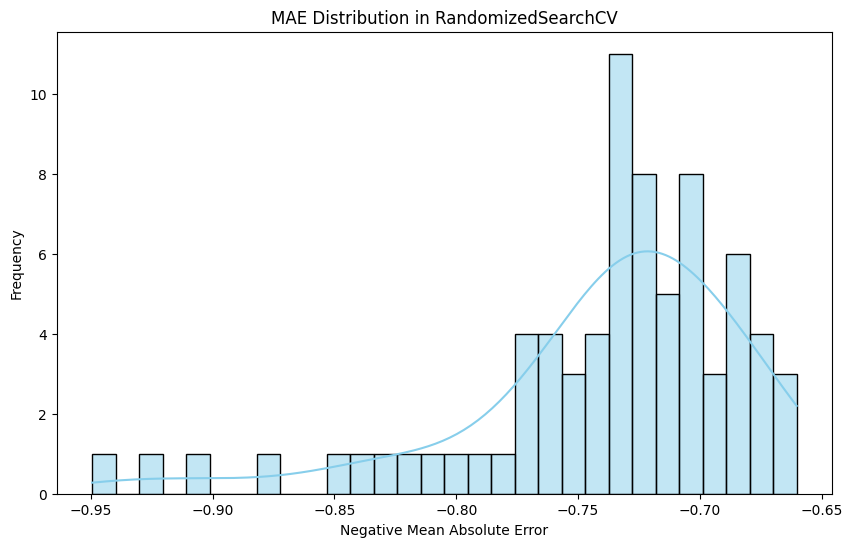

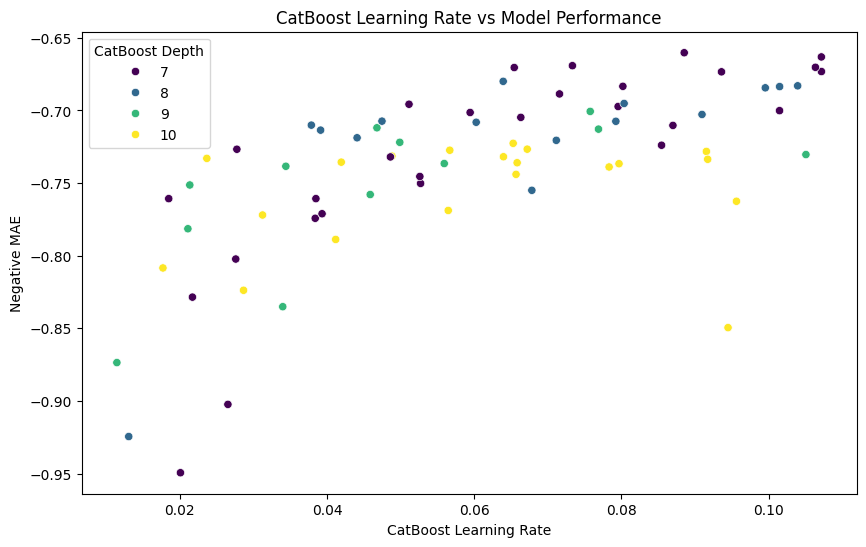

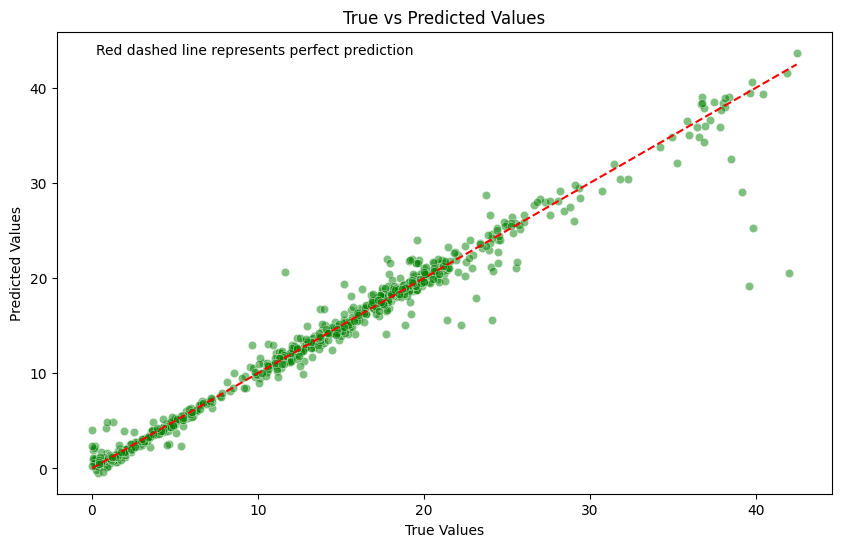

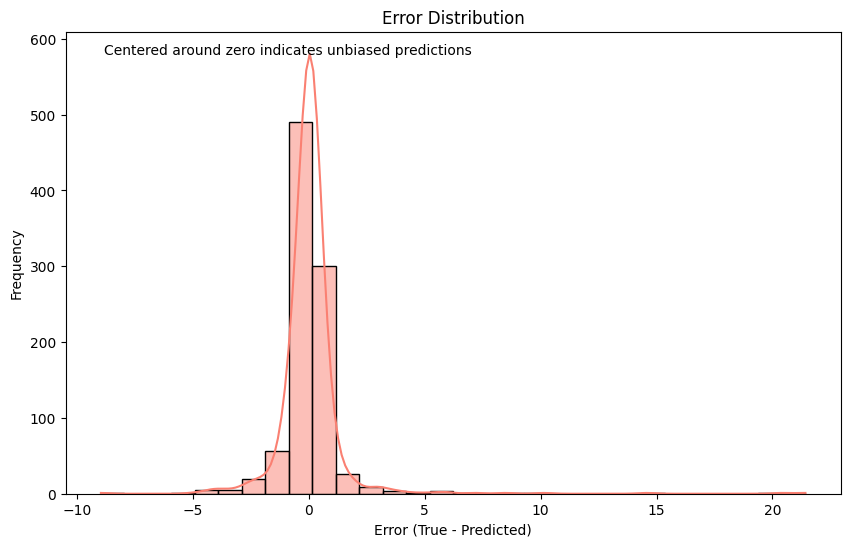

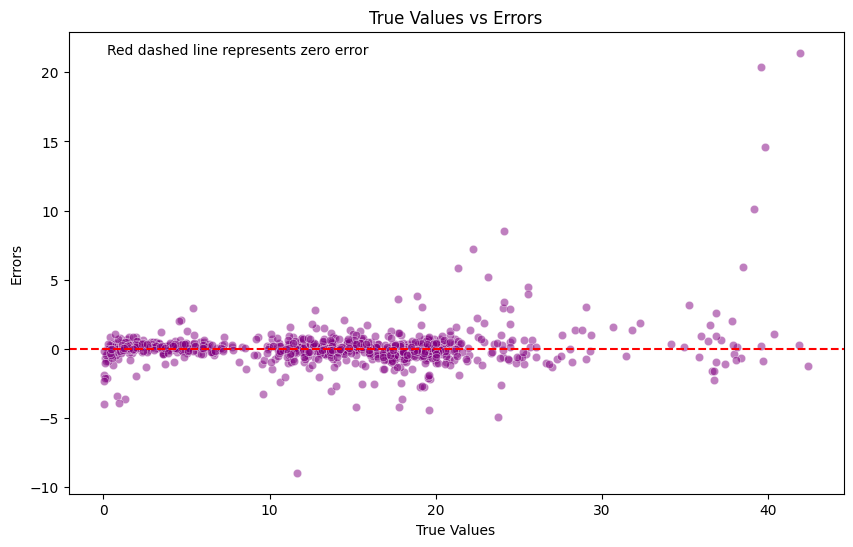

In [86]:
# رسم نتائج RandomizedSearchCV
plot_random_search_results(random_search)

# رسم أداء النموذج
plot_model_performance(y_test, y_pred)

# رسم متوسط مدة التواجد لكل يوم من أيام الأسبوع


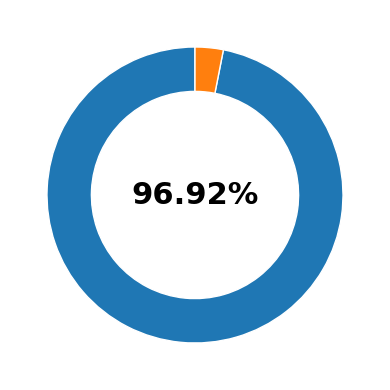

In [4]:
import matplotlib.pyplot as plt

r2 = 0.9692426011429311  # قيمة R²

fig, ax = plt.subplots(figsize=(4,4), subplot_kw=dict(aspect="equal"))
# مقطع ممتلئ
ax.pie([r2, 1-r2],
       radius=1,
       startangle=90,           # يبدأ من الأعلى
       wedgeprops=dict(width=0.3, edgecolor='white'))  # 0.3 = سماكة الدونات

# نص القيمة في المنتصف
ax.text(0, 0, f"{r2:.2%}", ha='center', va='center', fontsize=22, weight='bold')

# إزالة الإطار وخلفية شفافة
fig.patch.set_alpha(0.0)
ax.axis("off")

plt.tight_layout()
plt.savefig("r2_donut.png", dpi=300, transparent=True)
plt.show()


### 6. Loss History (Mean Absolute Error Distribution)

In [87]:
# Calculate average duration per hour
avg_duration_per_hour = df_model.groupby('Hour')['Duration_Hours'].mean().reset_index()

# Plot line chart
fig = px.line(
    avg_duration_per_hour,
    x='Hour',
    y='Duration_Hours',
    title='Average Duration Hours by Hour of the Day',
    labels={'Hour': 'Hour of the Day', 'Duration_Hours': 'Average Duration (Hours)'},
    markers=True,
    line_shape='spline',
    color_discrete_sequence=['orange']
)

fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Average Duration (Hours)'
)

fig.show()


### 7. Heatmap: Correlation Between Features and Duration

In [88]:
# Select numerical features for correlation
numerical_features = df_model.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_matrix = df_model[numerical_features].corr()

# Plot heatmap
fig = px.imshow(
    correlation_matrix,
    text_auto=True,
    aspect="auto",
    title='Correlation Heatmap of Features',
    color_continuous_scale='RdBu',
    labels=dict(color='Correlation Coefficient')
)

fig.update_layout(
    xaxis_title='Features',
    yaxis_title='Features'
)

fig.show()


### 8. Box Plot: Duration Hours by Day of the Week


In [89]:
fig = px.box(
    df_model,
    x='DayOfWeek',
    y='Duration_Hours',
    title='Distribution of Duration Hours by Day of the Week',
    labels={'DayOfWeek': 'Day of the Week', 'Duration_Hours': 'Duration (Hours)'},
    color='DayOfWeek',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Duration (Hours)'
)

fig.show()


### 9. Violin Plot: Duration Hours Distribution

In [90]:
fig = px.violin(
    df_model,
    x='IsWeekend',
    y='Duration_Hours',
    color='IsWeekend',
    box=True,
    points='all',
    title='Distribution of Duration Hours: Weekdays vs Weekends',
    labels={'IsWeekend': 'Is Weekend', 'Duration_Hours': 'Duration (Hours)'},
    color_discrete_sequence=['#636EFA', '#EF553B']
)

fig.update_layout(
    xaxis_title='Is Weekend',
    yaxis_title='Duration (Hours)'
)

fig.show()


### 10. Heatmap: Feature Interactions

In [91]:
# Create a pivot table for Temp and Humidity vs Duration_Hours
pivot_table = df_model.pivot_table(
    values='Duration_Hours',
    index='Temp',
    columns='Humidity',
    aggfunc='mean'
)

# Plot heatmap
fig = px.imshow(
    pivot_table,
    labels=dict(x="Humidity", y="Temperature", color="Avg Duration (Hours)"),
    title='Heatmap of Temperature vs Humidity vs Duration Hours',
    color_continuous_scale='Viridis'
)

fig.update_layout(
    xaxis_title='Humidity',
    yaxis_title='Temperature'
)

fig.show()


### 11. Network of diagrams

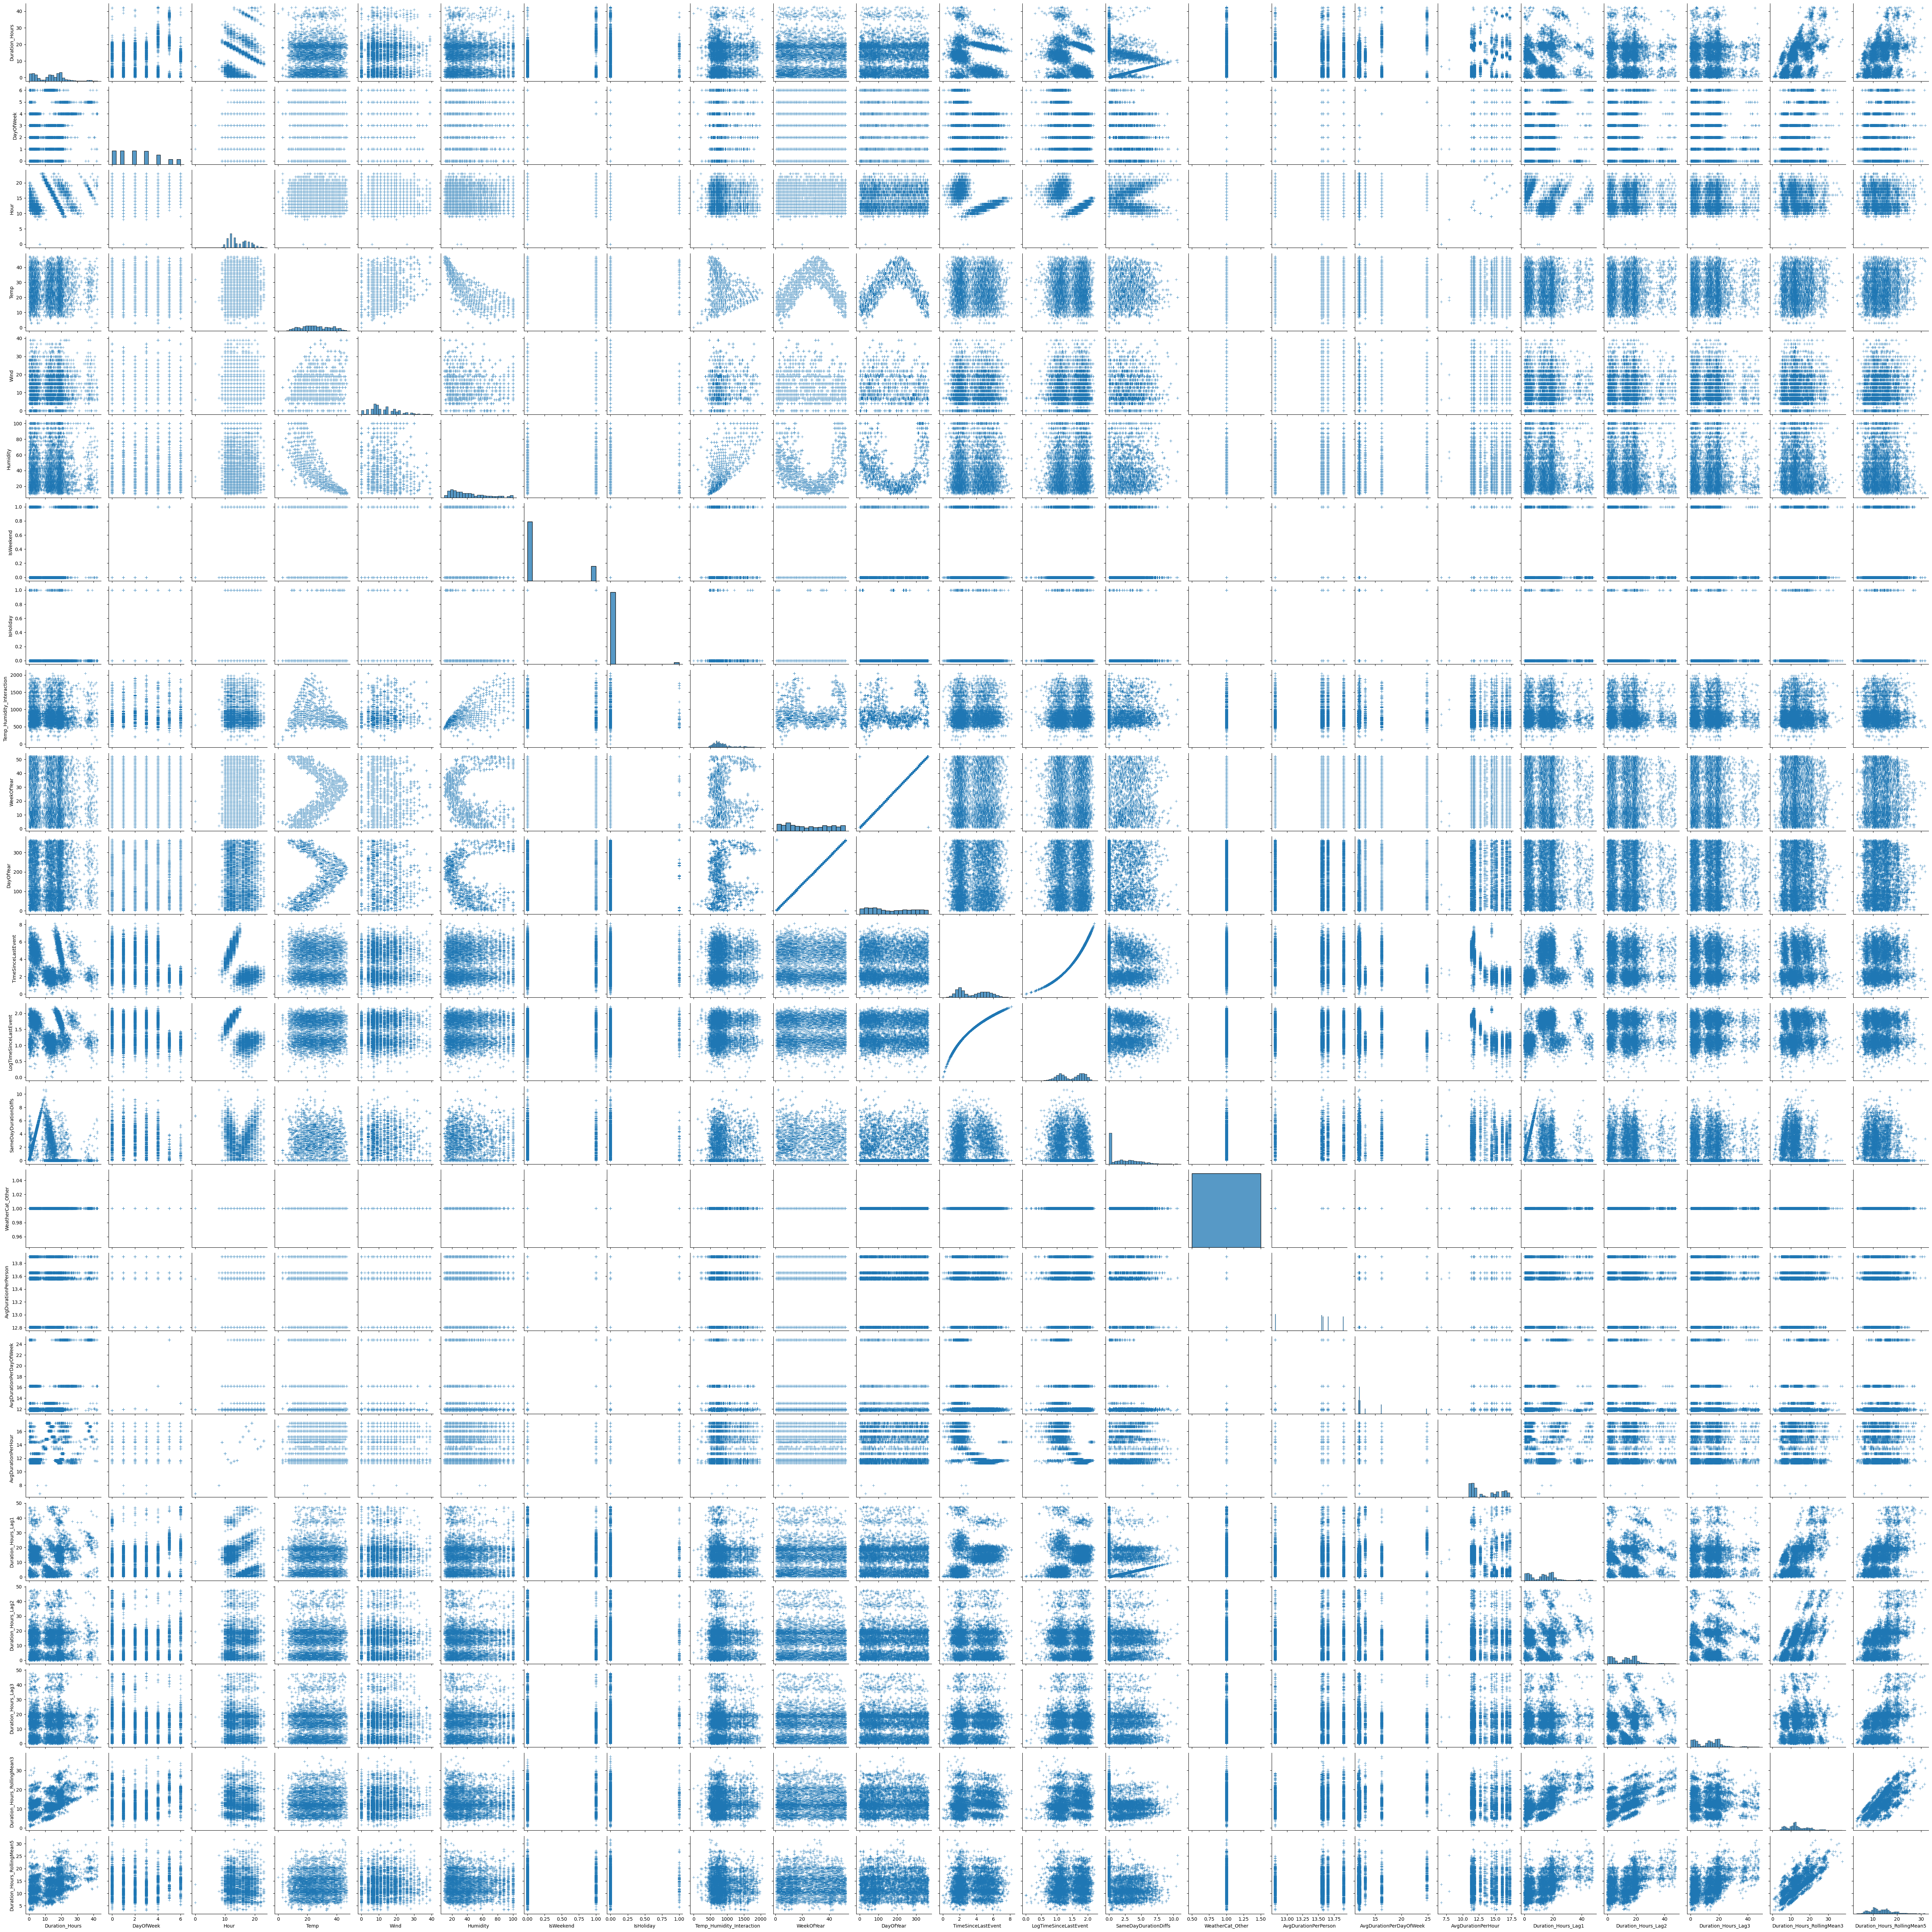

In [113]:
sns.pairplot(df_model, diag_kind = "hist", markers = "+") #kde #hist #None
plt.show()

<a id="3"></a>
# <p style="padding:10px;background-color:#273c75 ;margin:0;color:#E2EEF3;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> Prepare Sample, Predict </p>

In [112]:
# Cell 6: Load Model, Prepare Sample, Predict

def load_model_and_transformer(model_path, transformer_path):
    """
    تحميل النموذج ومحول هندسة الميزات المحفوظين باستخدام joblib.
    
    Args:
        model_path (str): مسار ملف النموذج المحفوظ.
        transformer_path (str): مسار ملف المحول المحفوظ.
    
    Returns:
        Pipeline: النموذج المحمل.
        FeatureEngineeringTransformer: المحول المحمل.
    """
    try:
        model = joblib.load(model_path)
        print("Model loaded successfully.")
    except FileNotFoundError:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")
    
    try:
        transformer = joblib.load(transformer_path)
        print("FeatureEngineeringTransformer loaded successfully.")
    except FileNotFoundError:
        raise FileNotFoundError(f"Transformer file '{transformer_path}' not found.")
    
    return model, transformer

def prepare_and_predict(sample_data, model, transformer):
    """
    تجهيز العينة للتنبؤ باستخدام النموذج المحمل.
    
    Args:
        sample_data (dict): بيانات العينة.
        model (Pipeline): النموذج المدرب.
        transformer (FeatureEngineeringTransformer): المحول المحمل.
    
    Returns:
        float: القيمة المتنبأة.
    """
    sample_df = pd.DataFrame(sample_data)
    sample_df['Timestamp'] = pd.to_datetime(sample_df['Timestamp'], errors='coerce')
    sample_df = transformer.transform(sample_df)
    
    try:
        predicted_hours = model.predict(sample_df)[0]
        print("Predicted hours to next exit:", predicted_hours)
        return predicted_hours
    except Exception as e:
        raise ValueError(f"An error occurred during prediction: {e}")

def main_predict():
    # مسارات الملفات
    model_path = '../models/optimized_stacking_regressor_advanced.pkl'
    transformer_path = '../models/feature_engineering_transformer.pkl'
    
    # تحميل النموذج ومحول هندسة الميزات
    model, transformer = load_model_and_transformer(model_path, transformer_path)
    
    # إنشاء عينة بيانات جديدة
    sample = {
        'Timestamp': ['2024-06-10 08:00:00'],
        'Weather': [2],  # استخدم الأكواد الرقمية للطقس وفقًا للتصنيفات المحددة (1 لـ 'Clear')
        'PersonID': ['Sara'],
        'Event': ['Enter'],
        'Temp': [35],       # درجة الحرارة
        'Wind': [5],        # سرعة الرياح
        'Humidity': [50],   # الرطوبة
        'DayOfWeek': [3],
        # يمكنك إضافة أي أعمدة أخرى إذا لزم الأمر
    }
    
    # تجهيز العينة والتنبؤ
    predicted_hours = prepare_and_predict(sample, model, transformer)
    
    # إرجاع العينة والقيمة المتنبأة
    return sample, predicted_hours

# تشغيل الدالة الرئيسية للتنبؤ وتخزين النتائج
sample, predicted_hours = main_predict()


Model loaded successfully.
FeatureEngineeringTransformer loaded successfully.
Predicted hours to next exit: 9.601606927069565


<a id="3"></a>
# <p style="padding:10px;background-color:#273c75 ;margin:0;color:#E2EEF3;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> Create a model prediction interface (streamlit) </p>

In [ ]:
! streamlit run app.py